# Bot Community Detection
Use this notebook to detect communities in bot retweet network

Data = Bot profiles, bot tweets

Analysis steps

1) Cluster bots based on retweet network (who they retweet)

2) Look at popular retweeted users, arabic profiles, and account creation dates within in bot retweet community.

3) Cluster bots by creation date.  Look at popular retweeted users and arabic profiles
in each created_at community


In [1]:
from datetime import datetime, timedelta
import numpy as np
import networkx as nx
from networkx.algorithms import community

import sqlite3,sys,os,string
import pandas as pd
import matplotlib.pyplot as plt
from os import path

from helper_retweet_network import *
from SpectralCommunities import spectral_clustering
from sklearn.cluster import KMeans

#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import arabic_reshaper
#from bidi.algorithm import get_display


## Load Data
1) fname_bots_db = file of database with bot tweets

2) fname_Gretweet = file where we will save bot retweet network

3) fname_Gsim = file where we will save retweet similarity network of bots

4) fname_bots_updated_csv = file where we save the bot profiles with community membership

In [9]:
path_data = "Libya//"

fname_bots_db = path_data+"Libya_bot_forensics.db"
fname_Gretweet = path_data + "Gretweet.gpickle"
fname_Gsim = path_data + "Gsim.gpickle"
fname_bots_updated_csv = path_data+"Libya_bot_forensics_community.csv"

conn = sqlite3.connect("%s"%fname_bots_db)
df_tweets = pd.read_sql_query("SELECT * FROM tweet", conn)
df_profiles = pd.read_sql_query("SELECT * FROM user_profile", conn)

print("%s bots\n%s bot tweets"%(len(df_profiles),len(df_tweets)))

2026 bots
413974 bot tweets


## Create and save retweet network


In [ ]:
#Gretweet = retweet_network_from_tweets(df_tweets)
#nx.write_gpickle(Gretweet, fname_Gretweet)

## Create and save similarity network

The similarity is based on the Jaccard index.  For each pair of bots we calculate the Jaccard index based on the sets of people they retweet.  If two bots retweet exactly the same users, their Jaccard index is one.  If they dont retweet anyone in common, their Jaccard index is zero.

In [ ]:
## Calculate Jacard similarity based on following for bots
V = list(set(df_profiles.screen_name))
print('%s bot profiles'%len(V))

ebunch = []
for counter,u in enumerate(V):
    for v in V[counter+1:]:
        if (Gretweet.has_node(v)) and (Gretweet.has_node(u)):
            ebunch.append((u,v))
preds = nx.jaccard_coefficient(Gretweet.to_undirected(),ebunch)
print(len(ebunch), " node pairs to check Jaccard index")

print("Create similarity graph between bots using Jacard index based on retweets")
counter = 0
Gsim = nx.Graph()
ne = 0
for u, v, s in preds:
    counter+=1
    if s >0:
        Gsim.add_edge(u, v, weight=s)
        ne+=1
    if counter%1e6==0:print(counter,ne, " positive weights")
nv = Gsim.number_of_nodes()
ne = Gsim.number_of_edges()
print("Gsim has %s nodes, %s edges"%(nv,ne))

print("Save similarity graph Gsim")
#nx.write_gpickle(Gsim, fname_Gsim)



## Create datetime objects from created at times of accounts.

We will look for temporal clusters.  Add column created_at_datetime to df_profiles with creation time as a datetime object for analysis purposes.

In [11]:
fmt = '%Y-%m-%d %H:%M:%S'

Tdatetime = []
for s in df_profiles.created_at:
    date_time_obj = datetime.strptime(s, fmt)
    Tdatetime.append(date_time_obj)
Tdatetime = np.array(Tdatetime)
df_profiles["created_at_datetime"]  = Tdatetime
t0 = min(Tdatetime)


# Community detection based on retweet network
1) Load retweet network Gretweet

2) Load bot retweet similarity network Gsim


In [4]:
Gretweet = nx.read_gpickle(fname_Gretweet)
Gsim = nx.read_gpickle(fname_Gsim)

## Find communities in bot retweet similarity
1) Choose number of communities to find k

2) Apply spectral clustering to Gsim to find communities

Community = list of communities.  Each element is a list of screen_names in a community

In [15]:
## Find spectral communities in the weighted similarity graph.

k = 3 #number of spectal communities 

Community = spectral_clustering(Gsim,k)
print("Found %s spectral communities"%len(Community))


for counter,community in enumerate(Community): 
    print("Retweet Community %s with %s nodes"%(counter,len(community)))

Found 3 spectral communities
Retweet Community 0 with 1073 nodes
Retweet Community 1 with 757 nodes
Retweet Community 2 with 195 nodes


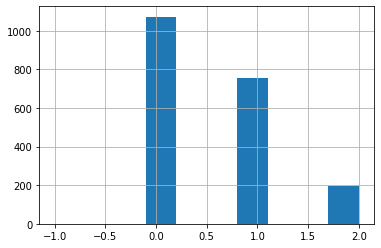

In [16]:
#add Community column to df_profiles dataframe
Community_dict ={}

for counter,community in enumerate(Community): 
    for v in community:
        Community_dict[v] = counter
Community_list = []
for v in df_profiles.screen_name:
    if v in Community_dict:
        Community_list.append(Community_dict[v])
    else:
        Community_list.append(-1) 
df_profiles['Community'] = Community_list
df_profiles.to_csv(fname_bots_updated_csv)

plt.hist(df_profiles.Community)
plt.grid()
plt.show()

## Top retweeted users in each community

For each community of bots, we form the subgraph containing the bots and everyone they retweet.  Then we look at the top retweeted users in this subgraph.

In [26]:
display_max = 10  #number of nodes to display

for counter,c in enumerate(Community):
    Vsub = []
    for v in c:
        if Gretweet.has_node(v):
            nb = list(Gretweet.predecessors(v))
            Vsub+=nb
            Vsub.append(v)
    print("Retweet community %s with %s users"%(counter,len(c)))
    G = Gretweet.subgraph(Vsub)
    Dout = dict(G.out_degree())
    print("Top out degree")
    Centrality = Dout
    display_top_centrality_nodes(Centrality,display_max)


Retweet community 0 with 1073 users
Top out degree
	Centrality = 512.00,  monther72
	Centrality = 457.00,  TurkeyAffairs
	Centrality = 424.00,  5a1di
	Centrality = 392.00,  AlArabiya
	Centrality = 377.00,  meshaluk
	Centrality = 357.00,  70sul
	Centrality = 318.00,  AlArabiya_Brk
	Centrality = 300.00,  sattam_al_saud
	Centrality = 289.00,  amjadt25
	Centrality = 289.00,  naif4002
	Centrality = 287.00,  Alshaikh2
Retweet community 1 with 757 users
Top out degree
	Centrality = 421.00,  EbrahimGasuda
	Centrality = 374.00,  emad_badish
	Centrality = 320.00,  RD_turk
	Centrality = 304.00,  nasser_duwailah
	Centrality = 296.00,  TurkiShalhoub
	Centrality = 295.00,  QATARTEAM
	Centrality = 294.00,  full_confident
	Centrality = 275.00,  Hamza_tekin2023
	Centrality = 270.00,  mshinqiti
	Centrality = 229.00,  aa_arabic
	Centrality = 228.00,  akarh90
Retweet community 2 with 195 users
Top out degree
	Centrality = 152.00,  tcsavunma
	Centrality = 113.00,  FazilDuygun
	Centrality = 109.00,  drfahre

## Arabic language profiles in each bot retweet community

Look at what fraction of user profiles in each bot retweet community contain Arabic characters

In [25]:
## functions to detect if a string has arabic characters
def isarabic_char(ch):
    if ('\u0600' <= ch <= '\u06FF' or
        '\u0750' <= ch <= '\u077F' or
        '\u08A0' <= ch <= '\u08FF' or
        '\uFB50' <= ch <= '\uFDFF' or
        '\uFE70' <= ch <= '\uFEFF' or
        '\U00010E60' <= ch <= '\U00010E7F' or
        '\U0001EE00' <= ch <= '\U0001EEFF' or
                        ch == '\U0001F1E6' or #saudi flag emoji
                        ch == '\U0001F1E6'): #saudi flag emoji
        return True
    else:
        return False
    
def isarabic_str(str):
    x = False
    for ch in str:
        if isarabic_char(ch): 
            x = True
            break
    return(x)

## Look at fraction of arabic profiles in each community
for counter,c in enumerate(Community):
    for cv,v in enumerate(c):
        if cv ==0:
            profiles = df_profiles.description[df_profiles.screen_name==v]
        else:
            profile = df_profiles.description[df_profiles.screen_name==v]
            profiles = profiles.append(profile)
    n = len(profiles)
    narabic = sum([isarabic_str(p) for p in profiles])

    print("Community %s: %s users, %.2f percent arabic profiles"
          %(counter,n,narabic/n))

ArabicProfile = []   
for profile in df_profiles.description:
    ArabicProfile.append(isarabic_str(profile))
ArabicProfile = np.array(ArabicProfile)
df_profiles["arabic_profile"]  = ArabicProfile
df_profiles.to_csv(fname_bots_updated_csv)


Community 0: 1073 users, 0.41 percent arabic profiles
Community 1: 757 users, 0.41 percent arabic profiles
Community 2: 195 users, 0.03 percent arabic profiles


## Histogram of Creation date in each bot retweet community
Plot distribution of creation dates for bots in each retweet based community

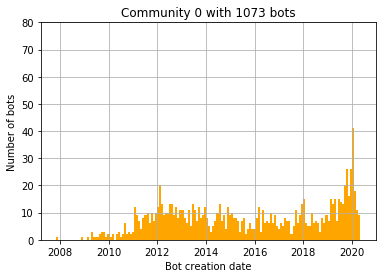

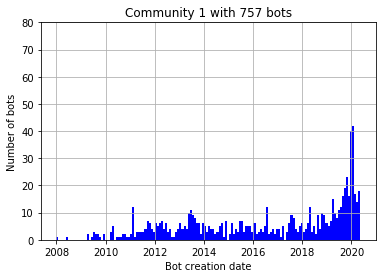

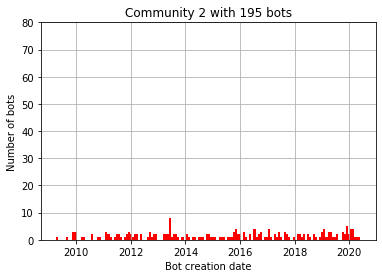

In [23]:
t0 = min(df_profiles.created_at_datetime).to_pydatetime()
tf = max(df_profiles.created_at_datetime).to_pydatetime()

nbins = round((tf-t0).days/31)
color = ["orange","blue","red","green","yellow","pink","cyan"]
for counter,c in enumerate(Community):
    T =[]
    for v in c:
        t = df_profiles.created_at_datetime[df_profiles.screen_name==v].values[0]
        T.append(t)
    T = np.array(T)
    plt.hist(T,nbins,color = color[counter],
             label="Community %s with %s nodes"%(counter,len(c)))
    plt.title("Community %s with %s bots"%(counter,len(c)))
    plt.grid()
    plt.xlabel("Bot creation date")
    plt.ylabel("Number of bots")
    plt.ylim([0,80])
    plt.show()

# CDF Plots and Windowed Histograms of Bot creation date grouped by retweet community

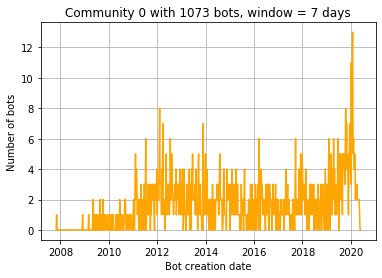

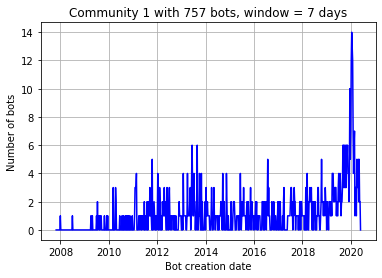

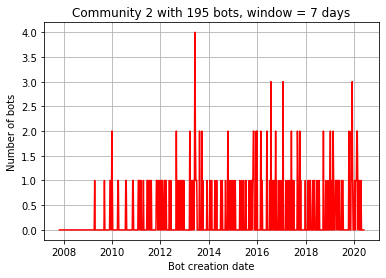

In [20]:
def cdf_created_at(df,t0,t1,window_days):
    #zero out the hours, minutes, seconds, microseconds
    tf_bin = tf.replace(hour=0, minute=0, second=0, microsecond=0) # Returns a copy
    t0_bin = t0.replace(hour=0, minute=0, second=0, microsecond=0) # Returns a copy

    bins = []
    delta = timedelta(days=window_days)
    GO = True
    counter_days=0
    while GO:
        t1 = t0_bin + counter_days*delta
        if t1 >tf_bin:
            GO = False
            break
        else:
            bins.append(t1)
            counter_days+=1
    bins = np.array(bins)
    Cum_count = []
    Hist_count = []
    for t in bins:
        cdf = len(df[df.created_at_datetime<=t])
        hist_count =  len(df[(df.created_at_datetime<=t) & (df.created_at_datetime>t-delta)])
        Cum_count.append(cdf)
        Hist_count.append(hist_count)
    Cum_count = np.array(Cum_count)
    CDF = Cum_count/max(Cum_count)
    
    bins = [timestamp.date() for timestamp in bins]
    return bins,Cum_count,Hist_count

t0 = min(df_profiles.created_at_datetime)
tf = max(df_profiles.created_at_datetime)

nbins = round((tf-t0).days/7)
color = ["orange","blue","red","green"]
window_days = 7
for counter,c in enumerate(Community):
    df_comm = df_profiles[df_profiles.Community==counter]
    bins,CDF,Hist_count =  cdf_created_at(df_comm,t0,tf,window_days)
    
    #plt.subplot(1,2,2)
    #plt.plot(bins,CDF,color = color[counter],
    #         label="Community %s with %s nodes"%(counter,len(c)))
    #plt.title("Community %s with %s bots"%(counter,len(c)))
    #plt.grid()
    #plt.xlabel("Bot creation date")
    #plt.ylabel("Cumulative Fraction of bots")
    #plt.ylim([0,80])
    #plt.subplot(1,2,1)
    plt.plot(bins,Hist_count,color = color[counter],
             label="Community %s with %s nodes"%(counter,len(c)))
    #plt.title("Community %s with %s bots"%(counter,len(c)))
    plt.grid()
    plt.xlabel("Bot creation date")
    plt.ylabel("Number of bots")
    plt.title("Community %s with %s bots, window = %s days"%(counter,len(c),window_days))

    #plt.ylim([0,80])
    plt.show()


In [22]:
## Get accounts for each community created in a given time window
window_days = 7  #length of time window to look in
bot_lim = 10
t0 = min(df_profiles.created_at_datetime)
tf = max(df_profiles.created_at_datetime)

bins,CDF,Hist_count =  cdf_created_at(df_profiles,t0,tf,window_days)
print("All %s accounts"%(len(df_profiles)))
for counter1,t in enumerate(bins[0:-1]):
    n = Hist_count[counter1]
    t1 = bins[counter1+1]
    if n>=bot_lim:
        #print("\t%s to %s: %s bots made"%(t,t1,n))
        1
            
for counter,c in enumerate(Community):
    df_comm = df_profiles[df_profiles.Community==counter]
    bins,CDF,Hist_count =  cdf_created_at(df_comm,t0,tf,window_days)
    print("Community %s with %s accounts"%(counter,len(df_comm)))
    for counter1,t in enumerate(bins[0:-1]):
        n = Hist_count[counter1]
        t1 = bins[counter1+1]
        
        dt1 =datetime.combine(t1, datetime.min.time())
        dt = datetime.combine(t, datetime.min.time())
        if n>=bot_lim:
            print("\t%s to %s: %s bots made"%(t,t1,n))
            mask1 = (pd.to_datetime(df_comm.created_at_datetime)>dt)
            mask2 = (pd.to_datetime(df_comm.created_at_datetime)<=dt1)
            Bots_in_window = df_comm[mask1 & mask2]
            fname = path_data + "Bots_Community_%s_%s_to_%s.csv"%(counter,t,t1)
            Bots_in_window.to_csv(fname)
            #for bot in Bots_in_window.screen_name:
                

All 2026 accounts
Community 0 with 1073 accounts
	2020-01-07 to 2020-01-14: 11 bots made
	2020-01-21 to 2020-01-28: 11 bots made
	2020-01-28 to 2020-02-04: 13 bots made
Community 1 with 757 accounts
	2019-12-17 to 2019-12-24: 10 bots made
	2020-01-07 to 2020-01-14: 12 bots made
	2020-01-14 to 2020-01-21: 14 bots made
	2020-01-21 to 2020-01-28: 13 bots made
	2020-01-28 to 2020-02-04: 12 bots made
Community 2 with 195 accounts


# Community detection based on account creation time
Apply k-means clustering to created_at.  

Add column community_created_at to df_profiles with community membership for each profile


center 0: 2012-03-01 06:29:29.609231, 654 accounts
center 1: 2019-04-18 04:47:37.431604, 847 accounts
center 2: 2015-08-26 17:56:47.215909, 525 accounts


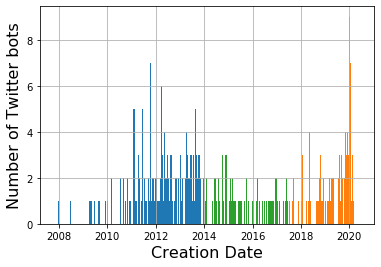

In [10]:
Xdays = np.array([(t-t0).total_seconds()/(3600*24) for t in Tdatetime])
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xdays.reshape(-1,1))
df_profiles['community_created_at'] = kmeans.labels_



t0 = min(df_profiles.created_at_datetime).to_pydatetime()
tf = max(df_profiles.created_at_datetime).to_pydatetime()

nbins = round((tf-t0).days/7)
for counter,center1 in enumerate(kmeans.cluster_centers_):
    T = df_profiles.created_at_datetime[df_profiles.community_created_at ==counter]
    ncom = len(T)
    center = t0+timedelta(days=center1[0])
    print("center %s: %s, %s accounts"%(counter,center,ncom))
    plt.hist(T,bins = nbins)
plt.grid()
plt.xlabel("Creation Date", fontsize = 16)
plt.ylabel("Number of Twitter bots", fontsize = 16)
plt.show()

## create list of screen names of users in communities
CommunityCreatedAt =[]
for c,center in enumerate(kmeans.cluster_centers_):
    l = list(df_profiles.screen_name[df_profiles.community_created_at==c])
    CommunityCreatedAt.append(l)

In [ ]:
#CDF of creation times of bots
tf_bin = tf.replace(hour=0, minute=0, second=0, microsecond=0) # Returns a copy
t0_bin = t0.replace(hour=0, minute=0, second=0, microsecond=0) # Returns a copy

bins = []
ndays = 1
delta = timedelta(days=ndays)
GO = True
counter_days=0
while GO:
    t1 = t0_bin + counter_days*delta
    if t1 >tf_bin:
        GO = False
        break
    else:
        bins.append(t1)
        counter_days+=1
bins = np.array(bins)
CDF = []
for t in bins:
    cdf = len(df_profiles[df_profiles.created_at_datetime<=t])
    CDF.append(cdf)
CDF = np.array(CDF)
CDF_n = CDF/max(CDF)
plt.plot(bins,CDF_n,color = 'orange')
plt.grid()
plt.xlabel("Bot creation date")
plt.ylabel("Fraction of bots") 
plt.show()

plt.plot(bins,CDF,color = 'blue')
plt.grid()
plt.xlabel("Bot creation date")
plt.ylabel("Number of bots") 
plt.show()

## Top retweeted users in each created_at community


In [12]:
display_max = 5  #number of nodes to display

for counter,c in enumerate(CommunityCreatedAt):
    Vsub = []
    for v in c:
        if Gretweet.has_node(v):
            nb = list(Gretweet.predecessors(v))
            Vsub+=nb
    print("Created_at community %s with %s users"%(counter,len(c)))
    G = Gretweet.subgraph(Vsub)
    Dout = dict(G.out_degree())
    print("Top out degree")
    Centrality = Dout
    display_top_centrality_nodes(Centrality,display_max)


Created_at community 0 with 654 users
Top out degree
	Centrality = 41.00,  monther72
	Centrality = 35.00,  5a1di
	Centrality = 33.00,  TurkeyAffairs
	Centrality = 31.00,  tcsavunma
	Centrality = 30.00,  AlArabiya
	Centrality = 25.00,  70sul
Created_at community 1 with 847 users
Top out degree
	Centrality = 68.00,  EbrahimGasuda
	Centrality = 58.00,  TurkeyAffairs
	Centrality = 57.00,  monther72
	Centrality = 55.00,  emad_badish
	Centrality = 45.00,  RD_turk
	Centrality = 44.00,  AlArabiya
Created_at community 2 with 525 users
Top out degree
	Centrality = 32.00,  emad_badish
	Centrality = 30.00,  EbrahimGasuda
	Centrality = 28.00,  RD_turk
	Centrality = 28.00,  monther72
	Centrality = 25.00,  TurkeyAffairs
	Centrality = 25.00,  QATARTEAM


## Arabic language profiles

Look at what fraction of user profiles in each created_at community contain Arabic characters

In [11]:
for counter,c in enumerate(CommunityCreatedAt):
    for cv,v in enumerate(c):
        if cv ==0:
            profiles = df_profiles.description[df_profiles.screen_name==v]
        else:
            profile = df_profiles.description[df_profiles.screen_name==v]
            profiles = profiles.append(profile)
    n = len(profiles)
    narabic = sum([isarabic_str(p) for p in profiles])

    print("Created_at Community %s: %s users, %.2f percent arabic profiles"
          %(counter,n,narabic/n))

Created_at Community 0: 654 users, 0.32 percent arabic profiles
Created_at Community 1: 847 users, 0.42 percent arabic profiles
Created_at Community 2: 525 users, 0.34 percent arabic profiles


## Compare Arabic to non-Arabic profiles

Calculate which bot profiles have arabic characters and add arabic_profile boolean column to df_profiles

In [12]:
Arabic = []
for p in df_profiles.description:
    arabic = isarabic_str(p)
    Arabic.append(arabic)
df_profiles["arabic_profile"]  = Arabic
narabic = len(df_profiles[df_profiles.arabic_profile])
n = len(df_profiles)
print("%s bots, %s arabic profiles"%(n,narabic))

2026 bots, 750 arabic profiles


## Histogram of created_at for Arabic and non-arabic profiles

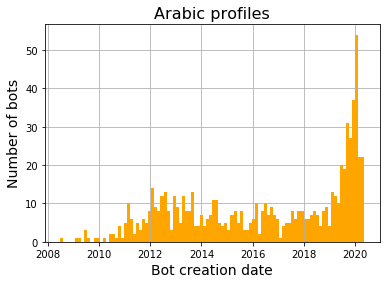

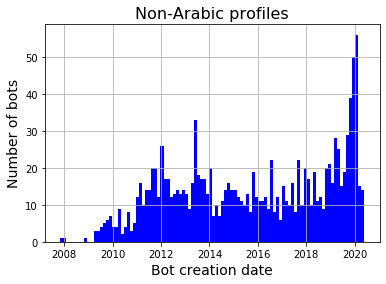

In [13]:
nbins = 100
plt.hist(df_profiles.created_at_datetime[df_profiles.arabic_profile==True],
         label = "Arabic profiles",color = "orange",bins = nbins)
plt.grid()
plt.title("Arabic profiles",fontsize = 16)
plt.xlabel("Bot creation date",fontsize = 14)
plt.ylabel("Number of bots",fontsize = 14)
plt.show()

plt.hist(df_profiles.created_at_datetime[df_profiles.arabic_profile==False],
         label = "Non-Arabic profiles",color = "blue",bins = nbins)
plt.grid()
plt.title("Non-Arabic profiles",fontsize = 16)
plt.xlabel("Bot creation date",fontsize = 14)
plt.ylabel("Number of bots",fontsize = 14)

plt.show()


Text(0, 0.5, 'Number of bots')

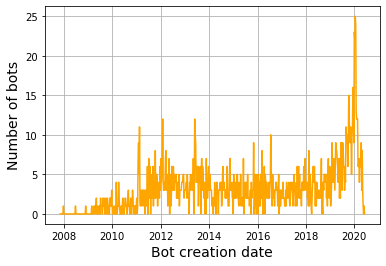

In [80]:
## Look at number of bots created in each day
t0 = min(df_profiles.created_at_datetime).to_pydatetime()
tf = max(df_profiles.created_at_datetime).to_pydatetime()
ndays = 7 #temporal window to look for bot creations
delta = timedelta(days=ndays)

t1 = t0
Nbots =[]
T = []
while t1<tf:
    t1 = t1+delta
    nbots = len(df_profiles[(df_profiles.created_at_datetime>=t1) &
                            (df_profiles.created_at_datetime<t1+delta)])
    Nbots.append(nbots)
    T.append(t1)

plt.plot(T,Nbots,color = 'orange')
plt.grid()
plt.xlabel("Bot creation date",fontsize = 14)
plt.ylabel("Number of bots",fontsize = 14)


In [82]:
(tf-t0).days

4593